In [31]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [32]:
# Step 1: Load the Datasets
data1A = pd.read_csv("/Users/supak/Desktop/DDoS 2018/02-15-2018.csv", low_memory=False)
data2A = pd.read_csv("/Users/supak/Desktop/DDoS 2018/02-21-2018.csv", low_memory=False)

#-----------Customized part for each particular datasets--------------
# # List of columns to drop
# columns_to_drop = ['Flow ID', 'Src Port', 'Src IP', 'Dst IP']
# # Drop the specified columns from data1
# data1AD = data1A.drop(columns=columns_to_drop, errors='ignore')
# Randomly sample 1/10 of the data
data1 = data1A.sample(frac=1, random_state=42)  # frac=0.1 means 10%, random_state ensures reproducibility
print(data1.head())
data2 = data2A.sample(frac=1, random_state=42)  # frac=0.1 means 10%, random_state ensures reproducibility
print(data2.head())
#-----------Customized part for each particular datasets--------------


        Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
781974       443         6  15/02/2018 10:35:25      115977940            28   
937737      3128         6  15/02/2018 09:33:53        1002481             2   
907828       443         6  15/02/2018 03:32:20       60108102             4   
784628        53        17  15/02/2018 10:53:26          13854             1   
662460       443         6  15/02/2018 08:59:56            326             3   

        Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
781974            30             2188            22138              918   
937737             0                0                0                0   
907828             2              147              252               74   
784628             1               44              198               44   
662460             0               53                0               53   

        Fwd Pkt Len Min  ...  Fwd Seg Size Min   Active Mean    Acti

In [33]:
# Step 2: Preprocess the Data (Selecting Specific Columns)
def preprocess_data(data):
    data.columns = data.columns.str.strip()  # Remove whitespace from column names
    
    # Select only the required columns
    selected_columns = ['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Label']
    data = data[selected_columns].dropna()  # Drop rows with missing values
    
    # Encode the target column ('Label')
    encoder = LabelEncoder()
    data['Label'] = encoder.fit_transform(data['Label'])
    
    # Select only numeric columns for scaling
    numeric_columns = [col for col in selected_columns if col != 'Label']  # Exclude the target column
    
    # Check for infinite or extremely large values
    data[numeric_columns] = data[numeric_columns].replace([np.inf, -np.inf], np.nan)
    data = data.dropna(subset=numeric_columns)
    
    # Scale the numeric feature columns
    scaler = StandardScaler()
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
    
    X = data[numeric_columns]
    y = data['Label']
    
    # Return processed features, labels, and encoder
    return X, y, encoder
 
# Apply preprocessing to both datasets
X1, y1, encoder1 = preprocess_data(data1)
X2, y2, encoder2 = preprocess_data(data2)

/var/folders/zp/tzh3gq_17bn7fsmbmlcj5v080000gn/T/ipykernel_13441/57168622.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label'] = encoder.fit_transform(data['Label'])
/var/folders/zp/tzh3gq_17bn7fsmbmlcj5v080000gn/T/ipykernel_13441/57168622.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_columns] = data[numeric_columns].replace([np.inf, -np.inf], np.nan)


In [34]:
# Step 3: Split the Training Data
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [35]:
# Step 4: Train the Linear SVM and Initialize Random Forest (can add more parameters)
rf_model = RandomForestClassifier(
    n_estimators=100,            # Number of trees
    max_depth=10,                # Limit the depth of each tree
    min_samples_split=5,         # Minimum samples for a split
    min_samples_leaf=3,          # Minimum samples at a leaf
    max_features='sqrt',         # Use sqrt(n_features) features for splits
    bootstrap=True,              # Use bootstrap sampling
    class_weight='balanced',     # Handle class imbalance
    random_state=42              # Reproducibility
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, min_samples_split=5,
                       random_state=42)

In [36]:
# Step 5: Validate the Model
y_val_pred = rf_model.predict(X_val)
print("Validation Results")
print(classification_report(y_val, y_val_pred))

Validation Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    108131
           1       1.00      1.00      1.00    205938
           2       1.00      1.00      1.00       504

    accuracy                           1.00    314573
   macro avg       1.00      1.00      1.00    314573
weighted avg       1.00      1.00      1.00    314573



In [ ]:
# Step 6: Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],   # Number of trees
    'max_depth': [10, 20, None],       # Tree depth (None means no limit)
    'min_samples_split': [2, 5, 10],   # Minimum samples to split
    'min_samples_leaf': [1, 3, 5],     # Minimum samples per leaf
    'max_features': ['sqrt', 'log2'],  # Number of features considered
    'bootstrap': [True, False]         # Bootstrap sampling
}
 
grid_search = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),  # Keep class balancing
    param_grid,
    cv=3,          # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,     # Use all available CPU cores
    verbose=2
)
 
# Perform Hyperparameter Search
grid_search.fit(X_train, y_train)
 
# Retrieve Best Parameters and Retrain
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
 
rf_model_best = RandomForestClassifier(
    **best_params, class_weight='balanced', random_state=42
)
rf_model_best.fit(X_train, y_train)
 

In [37]:
# Step 7: Test the Model
 
# y_test_pred = rf_model.predict(X2)
y_test_pred = rf_model_best.predict(X2) #With hyperparameters tuning
print("Test Results")
print(confusion_matrix(y2, y_test_pred))
print(classification_report(y2, y_test_pred))
print("Accuracy:", accuracy_score(y2, y_test_pred))

Test Results
[[986213      0   1837]
 [ 41508      0      0]
 [ 10990      0      0]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97    988050
           1       0.00      0.00      0.00     41508
           2       0.00      0.00      0.00     10990

    accuracy                           0.95   1040548
   macro avg       0.32      0.33      0.32   1040548
weighted avg       0.90      0.95      0.92   1040548

Accuracy: 0.9477823223916628


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


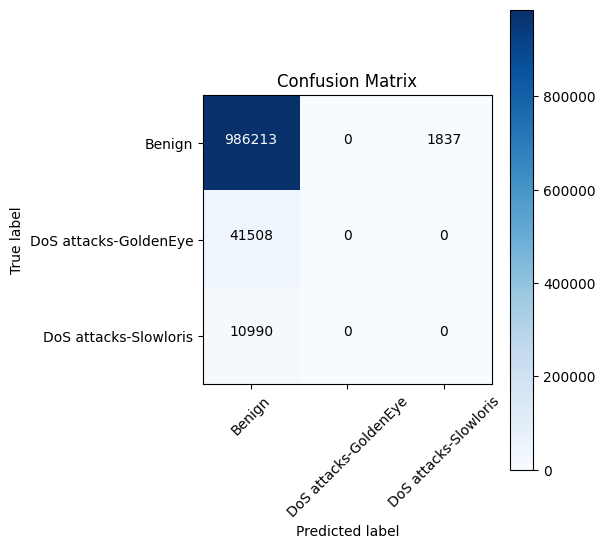

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

# Step 10: Confusion Matrix Visualization
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = "d"
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

# Confusion Matrix Plot
cm = confusion_matrix(y2, y_test_pred)
class_names = encoder2.inverse_transform(np.unique(y2))
plot_confusion_matrix(cm, class_names)

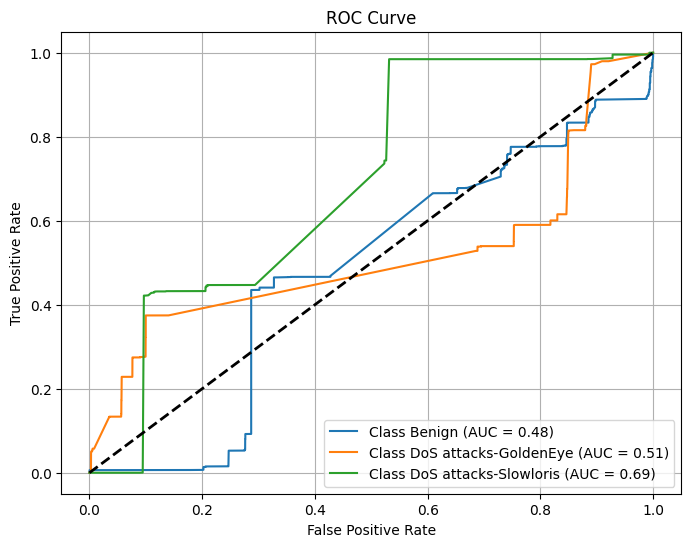

In [41]:
# Step 11: ROC Curve Visualization
y_test_prob = rf_model.predict_proba(X2)
plt.figure(figsize=(8, 6))
for i in range(y_test_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y2 == i, y_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.grid()
plt.show()